<a href="https://colab.research.google.com/github/ayaanzhaque/APCSP-Create/blob/master/inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install dicom_numpy
!pip install lpips

     |████████████████████████████████| 1.9MB 8.9MB/s 
  Created wheel for dicom-numpy: filename=dicom_numpy-0.5.0-py2.py3-none-any.whl size=6454 sha256=d49b240d9e7b7196ad2fcb584b0708ea24b6a802b005c4c4a3adda405a2b0dac
  Stored in directory: /root/.cache/pip/wheels/58/83/be/0beac28a5893128dbfb33419b024e5c7bd9ca62c8fdf8dd630
Successfully built dicom-numpy
     |████████████████████████████████| 61kB 4.8MB/s 


In [3]:
import os, re
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import dicom_numpy as dcm2np
import pydicom as dicom
import scipy.io as sio
import pdb

from skimage.transform import resize
from sklearn.model_selection import train_test_split

In [4]:
#Returns numpy array and image affine from a list of dicoms
def extract_voxel_data(list_of_dicom_files):
    datasets = [dicom.read_file(f) for f in list_of_dicom_files]
    try:
        ndarray, afn = dcm2np.combine_slices(datasets)
    except:
        print(len(datasets))
        pass
        #dicom_numpy.DicomImportException as e:
        # invalid DICOM data
        #raise
    for idx in range(ndarray.shape[-1]):
        ndarray[:,:,idx] = np.transpose(ndarray[:,:,idx], (1,0)) #transpose to align the axes [from (y, x) to (x, y)]
    return ndarray, afn

In [5]:
#Simulate low-dose
'''
Given: quarter dose and full dose CT images, required Dose level.
Return: Images at the Dose level
'''
def simulate_ld(I_qd, I_fd, Dose=1.):
    if Dose==1:
        return I_fd
    elif Dose==0.25:
        return I_qd
    else:
        a = np.sqrt(((1/Dose)-1)/3)
        #print(a)

        I_noise = I_qd - I_fd # extract the noise array by just subtracting the images

        return I_fd+(a*I_noise) # take the full dose and add the noise multiplied by a coefficient, which is a function inputting the requested dose


#Window-leveling
'''
input (before w/l image, window width, window center, newmax, newmin)
'''
def window_leveling(x, w, c, ymin=0, ymax=1.):
    sh = x.shape

    y = np.zeros(sh) #window-leveled image
    
    #print(x[x >= -110 & x < 189])
    #if (x <= c - 0.5 - (w-1) /2), then y = ymin
    mask1 = ( x <= (c - 0.5 - (w-1) /2) )
    y[mask1] = ymin #Update
    
    #else if (x > c - 0.5 + (w-1) /2), then y = ymax
    mask2 = ( x > (c - 0.5 + (w-1) /2) )
    y[mask2] = ymax #Update

    #else y = ((x - (c - 0.5)) / (w-1) + 0.5) * (ymax- ymin) + ymin
    mask3 = ( x > (c - 0.5 - (w-1) /2)) & (x <= (c - 0.5 + (w-1) /2) ) 
    np.putmask(y, mask3, ((x - (c - 0.5)) / (w-1) + 0.5) * (ymax- ymin) + ymin) #Update
    
    return y #return window-leveled image


#For each CT slice, do w/l and resizing if required
def prep_slices(volume, scale=512):
    resized_data = []
    
    for i in range(volume.shape[0]):
        img = window_leveling(volume[i], 300, 40) #width=300, center=40
        #print('Img max-min: ', np.max(img), np.min(img))
        
        #img = resize(img, [scale, scale]) #uncomment for resizing
        assert img.shape == (scale, scale)
        try:
            assert np.max(img) == 1.
            assert np.min(img) == 0.
        except:
            print('Wrong!')
        resized_data.append(img)
    
    resized_data = np.reshape(resized_data, [-1, scale, scale])

    return resized_data

#For each CT slice, do w/l and resizing if required
def prep_slices_no_window_leveling(volume, scale=512):
    resized_data = []
    
    for i in range(volume.shape[0]):
        # img = window_leveling(volume[i], 300, 40) #width=300, center=40
        #print('Img max-min: ', np.max(img), np.min(img))
        
        img = volume[i]

        # pdb.set_trace()

        #img = resize(img, [scale, scale]) #uncomment for resizing
        assert img.shape == (scale, scale)
        # try:
        #     assert np.max(img) == 1.
        #     assert np.min(img) == 0.
        # except:
        #     print('Wrong!')
        resized_data.append(img)
    
    resized_data = np.reshape(resized_data, [-1, scale, scale])

    return resized_data

In [6]:
ld_train = sio.loadmat("/content/drive/MyDrive/SSL_Ayaan/all_ct_data_5dose.mat")['ld_train']
fd_train = sio.loadmat("/content/drive/MyDrive/SSL_Ayaan/all_ct_data_5dose.mat")['fd_train']

ld_test = sio.loadmat("/content/drive/MyDrive/SSL_Ayaan/all_ct_data_5dose.mat")['ld_test']
fd_test = sio.loadmat("/content/drive/MyDrive/SSL_Ayaan/all_ct_data_5dose.mat")['fd_test']

chest_ld_test = sio.loadmat("/content/drive/MyDrive/SSL_Ayaan/test_chest_data_5dose.mat")['ld_test']
chest_fd_test = sio.loadmat("/content/drive/MyDrive/SSL_Ayaan/test_chest_data_5dose.mat")['fd_test']

print(ld_train.shape, ld_train.shape)
print(ld_test.shape, fd_test.shape)

(1533, 256, 256, 1) (1533, 256, 256, 1)
(663, 256, 256, 1) (663, 256, 256, 1)


In [7]:
# plt.imshow(np.squeeze(fd_train[10]), cmap='gray')

In [8]:
# plt.imshow(np.squeeze(ld_train[10]), cmap='gray')

In [9]:
# plt.imshow(np.squeeze(ld_train[0] - fd_train[0]), cmap='gray')

# Data Loading

In [10]:
import torch
from torch import nn,optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torchsummary import summary
import lpips

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from skimage.util import random_noise
from sklearn.preprocessing import normalize
from IPython.display import Image
import skimage.metrics as skmetrics

import time
from collections import defaultdict
from itertools import cycle
import gc
from math import exp
from torch.autograd import Variable
import torch.nn.init as init

In [11]:
class CT_Dataset(Dataset):
    def __init__(self, inputs, targets, transform=None):

        self.input_ = inputs
        self.target_ = targets
        self.transform = transform

    def __len__(self):
        return len(self.target_)

    def __getitem__(self, idx):
        input_img, target_img = self.input_[idx], self.target_[idx]

        if self.transform:
            input_img = self.transform(input_img)
            target_img = self.transform(target_img)
        
        
        return (input_img, target_img)

# Models

In [12]:
class RED_CNN(nn.Module):
    def __init__(self, img_ch = 1, out_ch=96):
        super(RED_CNN, self).__init__()
        self.conv1 = nn.Conv2d(img_ch, out_ch, kernel_size=5, stride=1, padding=0)
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=5, stride=1, padding=0)
        self.conv3 = nn.Conv2d(out_ch, out_ch, kernel_size=5, stride=1, padding=0)
        self.conv4 = nn.Conv2d(out_ch, out_ch, kernel_size=5, stride=1, padding=0)
        self.conv5 = nn.Conv2d(out_ch, out_ch, kernel_size=5, stride=1, padding=0)

        self.tconv1 = nn.ConvTranspose2d(out_ch, out_ch, kernel_size=5, stride=1, padding=0)
        self.tconv2 = nn.ConvTranspose2d(out_ch, out_ch, kernel_size=5, stride=1, padding=0)
        self.tconv3 = nn.ConvTranspose2d(out_ch, out_ch, kernel_size=5, stride=1, padding=0)
        self.tconv4 = nn.ConvTranspose2d(out_ch, out_ch, kernel_size=5, stride=1, padding=0)
        self.tconv5 = nn.ConvTranspose2d(out_ch, img_ch, kernel_size=5, stride=1, padding=0)

        self.relu = nn.ReLU()

    def forward(self, x):
        # encoder
        residual_1 = x
        out = self.relu(self.conv1(x))
        out = self.relu(self.conv2(out))
        residual_2 = out
        out = self.relu(self.conv3(out))
        out = self.relu(self.conv4(out))
        residual_3 = out
        out = self.relu(self.conv5(out))

        # decoder
        out = self.tconv1(out)
        out += residual_3
        out = self.tconv2(self.relu(out))
        out = self.tconv3(self.relu(out))
        out += residual_2
        out = self.tconv4(self.relu(out))
        out = self.tconv5(self.relu(out))
        out += residual_1
        out = self.relu(out)

        return out

In [13]:
class DnCNN(nn.Module):
    def __init__(self, depth=17, n_channels=64, image_channels=1, use_bnorm=True, kernel_size=3):
        super(DnCNN, self).__init__()
        kernel_size = 3
        padding = 1
        layers = []

        layers.append(nn.Conv2d(in_channels=image_channels, out_channels=n_channels, kernel_size=kernel_size, padding=padding, bias=True))
        layers.append(nn.ReLU(inplace=True))
        for _ in range(depth-2):
            layers.append(nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=kernel_size, padding=padding, bias=False))
            layers.append(nn.BatchNorm2d(n_channels, eps=0.0001, momentum = 0.95))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(in_channels=n_channels, out_channels=image_channels, kernel_size=kernel_size, padding=padding, bias=False))
        self.dncnn = nn.Sequential(*layers)
        # self._initialize_weights()

    def forward(self, x):
        y = x
        out = self.dncnn(x)
        return y-out
        # return out

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.orthogonal_(m.weight)
                print('init weight')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)

In [14]:
def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
    ) 

def tconv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
    ) 

class UNet(nn.Module):

    def __init__(self):
        super().__init__()
                
        self.dconv_down1 = conv_block(1, 16)
        self.dconv_down2 = conv_block(16, 32)
        self.dconv_down3 = conv_block(32, 64)
        self.dconv_down4 = conv_block(64, 128)
        self.dconv_down5 = conv_block(128, 256)      

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up4 = conv_block(256 + 128, 128)
        self.dconv_up3 = conv_block(128 + 64, 64)
        self.dconv_up2 = conv_block(64 + 32, 32)
        self.dconv_up1 = conv_block(32 + 16, 16)
        
        self.conv_last = nn.Conv2d(16, 1, 1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   

        conv4 = self.dconv_down4(x)
        x = self.maxpool(conv4)

        x = self.dconv_down5(x)

        x = self.upsample(x)  
        x = torch.cat([x, conv4], dim=1)

        x = self.dconv_up4(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)       

        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1) 
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out

In [15]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.dconv_down1 = conv_block(1, 16)
        self.dconv_down2 = conv_block(16, 32)
        self.dconv_down3 = conv_block(32, 64)
        self.dconv_down4 = conv_block(64, 128)
        self.dconv_down5 = conv_block(128, 256)      

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up4 = tconv_block(256, 128)
        self.dconv_up3 = tconv_block(128, 64)
        self.dconv_up2 = tconv_block(64, 32)
        self.dconv_up1 = tconv_block(32, 16)
        
        self.conv_last = nn.Conv2d(16, 1, 1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   

        conv4 = self.dconv_down4(x)
        x = self.maxpool(conv4)

        x = self.dconv_down5(x)

        x = self.upsample(x)

        x = self.dconv_up4(x)
        x = self.upsample(x)

        x = self.dconv_up3(x)
        x = self.upsample(x)

        x = self.dconv_up2(x)
        x = self.upsample(x)
        
        x = self.dconv_up1(x)
        out = self.conv_last(x)
        
        return out

In [16]:
class VanillaVAE(nn.Module):
    def __init__(self, latent_dim = 256):
        super(VanillaVAE, self).__init__()

        self.dconv_down1 = conv_block(1, 16)
        self.dconv_down2 = conv_block(16, 32)
        self.dconv_down3 = conv_block(32, 64)
        self.dconv_down4 = conv_block(64, 128)
        self.dconv_down5 = conv_block(128, 256)      

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        # Build Bottleneck
        self.fc_mu = nn.Linear(256 * 4 * 4, latent_dim)
        self.fc_var = nn.Linear(256 * 4 * 4, latent_dim)

        # Build Decoder
        self.decoder_input = nn.Linear(latent_dim, 256 * 4 * 4)

        self.avgpool = nn.AdaptiveAvgPool2d((4,4))
        self.upsample2 = nn.Upsample(scale_factor= 4, mode='bilinear', align_corners=True)
        
        self.dconv_up4 = conv_block(256 + 128, 128)
        self.dconv_up3 = conv_block(128 + 64, 64)
        self.dconv_up2 = conv_block(64 + 32, 32)
        self.dconv_up1 = conv_block(32, 16)
        
        self.conv_last = nn.Conv2d(16, 1, 1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   

        conv4 = self.dconv_down4(x)
        x = self.maxpool(conv4)

        x = self.dconv_down5(x)

        result = self.avgpool(x)
        result = torch.flatten(result, start_dim=1)
        # Split the result into mu and var components of the latent Gaussian distribution
        mu = self.fc_mu(result)
        logvar = self.fc_var(result)

        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = eps * std + mu

        result = self.decoder_input(z)
        result = result.view(-1, 256, 4, 4)
        result = self.upsample2(result)

        x = self.upsample(result)  
        x = torch.cat([x, conv4], dim=1)

        x = self.dconv_up4(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)       

        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        # x = torch.cat([x, conv1], dim=1) 
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out, mu, logvar

In [17]:
class VAE_RED_CNN(nn.Module):
    def __init__(self, img_ch = 1, out_ch=96, latent_dim = 256):
        super(VAE_RED_CNN, self).__init__()
        self.conv1 = nn.Conv2d(img_ch, out_ch, kernel_size=5, stride=1, padding=0)
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=5, stride=1, padding=0)
        self.conv3 = nn.Conv2d(out_ch, out_ch, kernel_size=5, stride=1, padding=0)
        self.conv4 = nn.Conv2d(out_ch, out_ch, kernel_size=5, stride=1, padding=0)
        self.conv5 = nn.Conv2d(out_ch, out_ch, kernel_size=5, stride=1, padding=0)

        # Build Bottleneck
        self.fc_mu = nn.Linear(96 * 4 * 4, latent_dim)
        self.fc_var = nn.Linear(96 * 4 * 4, latent_dim)

        # Build Decoder

        self.decoder_input = nn.Linear(latent_dim, 96 * 4 * 4)

        self.avgpool = nn.AdaptiveAvgPool2d((4,4))
        self.upsample = nn.Upsample(scale_factor= (256 - 4 * 5)/4, mode='bilinear', align_corners=True)

        self.tconv1 = nn.ConvTranspose2d(out_ch, out_ch, kernel_size=5, stride=1, padding=0)
        self.tconv2 = nn.ConvTranspose2d(out_ch, out_ch, kernel_size=5, stride=1, padding=0)
        self.tconv3 = nn.ConvTranspose2d(out_ch, out_ch, kernel_size=5, stride=1, padding=0)
        self.tconv4 = nn.ConvTranspose2d(out_ch, out_ch, kernel_size=5, stride=1, padding=0)
        self.tconv5 = nn.ConvTranspose2d(out_ch, img_ch, kernel_size=5, stride=1, padding=0)

        self.relu = nn.ReLU()

    def forward(self, x):
        # encoder
        residual_1 = x
        out = self.relu(self.conv1(x))
        out = self.relu(self.conv2(out))
        residual_2 = out
        out = self.relu(self.conv3(out))
        out = self.relu(self.conv4(out))
        residual_3 = out
        out = self.relu(self.conv5(out))

        result = self.avgpool(out)
        result = torch.flatten(result, start_dim=1)
        # Split the result into mu and var components of the latent Gaussian distribution
        mu = self.fc_mu(result)
        logvar = self.fc_var(result)

        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = eps * std + mu

        result = self.decoder_input(z)
        result = result.view(-1, 96, 4, 4)
        result = self.upsample(result)

        # decoder
        out = self.tconv1(result)
        out += residual_3
        out = self.tconv2(self.relu(out))
        out = self.tconv3(self.relu(out))
        out += residual_2
        out = self.tconv4(self.relu(out))
        out = self.tconv5(self.relu(out))
        out += residual_1
        out = self.relu(out)

        return out, mu, logvar

# Training

## Loops

In [18]:
def compute_measure(x, y, pred, data_range = None):

    original_psnr = compute_PSNR(y, x, data_range)
    original_ssim = compute_SSIM(y, x, data_range)
    original_mse = compute_MSE(y, x)
    original_rmse = compute_RMSE(y, x)
    original_nrmse = compute_NRMSE(y, x)

    pred_psnr = compute_PSNR(y, pred, data_range)
    pred_ssim = compute_SSIM(y, pred, data_range)
    pred_mse = compute_MSE(y, pred)
    pred_rmse = compute_RMSE(y, pred)
    pred_nrmse = compute_NRMSE(y, pred)

    return (original_psnr, original_ssim, original_mse, original_rmse, original_nrmse), (pred_psnr, pred_ssim, pred_mse, pred_rmse, pred_nrmse)

def compute_MSE(img1, img2):
    return skmetrics.mean_squared_error(img1, img2)


def compute_RMSE(img1, img2):
    return np.sqrt(compute_MSE(img1, img2))

def compute_NRMSE(img1, img2):
    return skmetrics.normalized_root_mse(img1, img2)

def compute_PSNR(img1, img2, data_range = None):
    return skmetrics.peak_signal_noise_ratio(img1, img2)


def compute_SSIM(img1, img2, data_range = None, window_size=11, channel=1, size_average=True):

    img1 = np.reshape(img1, [-1, 256, 256])
    img2 = np.reshape(img2, [-1, 256, 256])


    total_ssim = 0

    for i in range(len(img1)):
      try:
        total_ssim += skmetrics.structural_similarity(img1[i], img2[i])
      except:
        pdb.set_trace()
    
    return total_ssim / len(img1)
    

def save_fig(x, y, pred, fig_name, original_result, pred_result, save_path = "/content/"):
    # x, y, pred = x.numpy(), y.numpy(), pred.numpy()
    f, ax = plt.subplots(1, 3, figsize=(30, 10))
    ax[0].imshow(np.squeeze(x[0]), cmap=plt.cm.gray)
    ax[0].set_title('LDCT', fontsize=30)
    ax[0].set_xlabel("PSNR: {:.4f}\nSSIM: {:.4f}\nMSE: {:.4f}\nRMSE: {:.4f}\nNRMSE: {:.4f}".format(original_result[0],
                                                                        original_result[1],
                                                                        original_result[2],
                                                                        original_result[3],
                                                                        original_result[4]), fontsize=20)
    # ax[0].xaxis.set_visible(False)
    # ax[0].yaxis.set_visible(False)

    # Predictions === \nPSNR avg: {:.4f} \nSSIM avg: {:.4f} \nMSE avg: {:.4f} \nRMSE avg: {:.4f} \nNRMSE avg: {:.4f}
    ax[1].imshow(np.squeeze(pred[0]), cmap=plt.cm.gray)
    # ax[1].xaxis.set_visible(False)
    # ax[1].yaxis.set_visible(False)
    ax[1].set_title('Prediction', fontsize=30)
    ax[1].set_xlabel("PSNR: {:.4f}\nSSIM: {:.4f}\nMSE: {:.4f}\nRMSE: {:.4f}\nNRMSE: {:.4f}".format(pred_result[0],
                                                                        pred_result[1],
                                                                        pred_result[2],
                                                                        pred_result[3],
                                                                        pred_result[4]), fontsize=20)
    ax[2].imshow(np.squeeze(y[0]), cmap=plt.cm.gray)
    # ax[2].xaxis.set_visible(False)
    # ax[2].yaxis.set_visible(False)
    ax[2].set_title('FDCT', fontsize=30)

    f.savefig(os.path.join(save_path, 'result_{}.png'.format(fig_name)))
    plt.close()

In [19]:
def test(model, test_loader, vae, mat_path = None):
      # load
      model.eval()

      # compute PSNR, SSIM, RMSE
      ori_psnr_avg, ori_ssim_avg, ori_mse_avg, ori_rmse_avg, ori_nrmse_avg = 0, 0, 0, 0, 0
      pred_psnr_avg, pred_ssim_avg, pred_mse_avg, pred_rmse_avg, pred_nrmse_avg= 0, 0, 0, 0, 0

      with torch.no_grad():
          for i, (x,y) in enumerate(test_loader):

              x, y = x.to(device=device, dtype=torch.float), y.to(device=device, dtype=torch.float)

              shape_ = x.shape[-1]

              if vae:
                pred, _, _ = model(x)
              else:
                pred = model(x)

              x = x.cpu().detach().numpy()
              y = y.cpu().detach().numpy()
              pred = pred.cpu().detach().numpy()

              # x = np.squeeze(x)
              # y = np.squeeze(y)
              # pred = np.squeeze(pred)

              original_result, pred_result = compute_measure(x, y, pred)
              
              ori_psnr_avg += original_result[0]
              ori_ssim_avg += original_result[1]
              ori_mse_avg += original_result[2]
              ori_rmse_avg += original_result[3]
              ori_nrmse_avg += original_result[4]

              pred_psnr_avg += pred_result[0]
              pred_ssim_avg += pred_result[1]
              pred_mse_avg += pred_result[2]
              pred_rmse_avg += pred_result[3]
              pred_nrmse_avg += pred_result[4]

              # def save_fig(self, x, y, pred, fig_name, original_result, pred_result):


              save_fig(x, y, pred, i, original_result, pred_result)

          # print('\n')
          # print('Original === \nPSNR avg: {:.4f} \nSSIM avg: {:.4f} \nMSE avg: {:.4f} \nRMSE avg: {:.4f} \nNRMSE avg: {:.4f}'.format(ori_psnr_avg/len(test_loader), 
          #                                                                                 ori_ssim_avg/len(test_loader), 
          #                                                                                 ori_mse_avg/len(test_loader),
          #                                                                                 ori_rmse_avg/len(test_loader),
          #                                                                                 ori_nrmse_avg/len(test_loader)
          #                                                                                 ))
          # print('\n')
          # print('Predictions === \nPSNR avg: {:.4f} \nSSIM avg: {:.4f} \nMSE avg: {:.4f} \nRMSE avg: {:.4f} \nNRMSE avg: {:.4f}'.format(pred_psnr_avg/len(test_loader), 
          #                                                                                       pred_ssim_avg/len(test_loader), 
          #                                                                                       pred_mse_avg/len(test_loader),
          #                                                                                       pred_rmse_avg/len(test_loader),
          #                                                                                       pred_nrmse_avg/len(test_loader)
          #                                                                                       ))
          # pdb.set_trace()
          return pred_psnr_avg/len(test_loader), pred_ssim_avg/len(test_loader), pred_mse_avg/len(test_loader), pred_rmse_avg/len(test_loader), pred_nrmse_avg/len(test_loader)

          # sio.savemat(mat_path, {'psnr': pred_psnr_avg/len(test_loader),
          #                        'ssim': pred_ssim_avg/len(test_loader),
          #                        'mse': pred_mse_avg/len(test_loader),
          #                        'rmse': pred_rmse_avg/len(test_loader),
          #                        'nrsme': pred_nrmse_avg/len(test_loader)})

## Load Data

In [20]:
transform = transforms.Compose([
  transforms.ToTensor(),
])

test_dataset = CT_Dataset(inputs = ld_test, targets = fd_test, transform = transform)

test_loader = DataLoader(dataset = test_dataset, batch_size = 10, shuffle = False, num_workers= 0)

dataloader = {
    'test': test_loader
}

print(len(dataloader['test']))

67


In [21]:
transform = transforms.Compose([
  transforms.ToTensor(),
])

cross_test_dataset = CT_Dataset(inputs = chest_ld_test, targets = chest_fd_test, transform = transform)

cross_test_loader = DataLoader(dataset = cross_test_dataset, batch_size = 10, shuffle = True, num_workers= 0)

cross_dataloader = {
    'test': cross_test_loader
}

print(len(cross_dataloader['test']))

107


## Start Training

In [22]:
gc.collect()
torch.cuda.empty_cache()

#pretext_downstream
# save_path = "/content/redcnn_250"
# mat_path = save_path + ".mat"
# checkpoint_path = save_path + ".pth"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RED_CNN().to(device)
# model = DnCNN().to(device)
# model = UNet().to(device)
# model = Autoencoder().to(device)
# model = VanillaVAE().to(device)
# model = VAE_RED_CNN().to(device)

summary(model, input_size=(1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 96, 252, 252]           2,496
              ReLU-2         [-1, 96, 252, 252]               0
            Conv2d-3         [-1, 96, 248, 248]         230,496
              ReLU-4         [-1, 96, 248, 248]               0
            Conv2d-5         [-1, 96, 244, 244]         230,496
              ReLU-6         [-1, 96, 244, 244]               0
            Conv2d-7         [-1, 96, 240, 240]         230,496
              ReLU-8         [-1, 96, 240, 240]               0
            Conv2d-9         [-1, 96, 236, 236]         230,496
             ReLU-10         [-1, 96, 236, 236]               0
  ConvTranspose2d-11         [-1, 96, 240, 240]         230,496
             ReLU-12         [-1, 96, 240, 240]               0
  ConvTranspose2d-13         [-1, 96, 244, 244]         230,496
             ReLU-14         [-1, 96, 2

# Evaluate

In [25]:
# model.load_state_dict(torch.load(checkpoint_path))
# model.load_state_dict(torch.load("/content/drive/MyDrive/SSL_Ayaan/test_full.pth"))

model_files = glob("/content/drive/MyDrive/SSL_Ayaan/tests/ssl/nac/redcnn_nac/*")
print(len(model_files))

def get_name(file):
  name = file.split("/")[9].split(".")[0]
  return name

print(get_name(model_files[0]))

20
redcnn_nac_250


In [ ]:
model_files

['/content/drive/MyDrive/SSL_Ayaan/tests/ssl/nac/redcnn_nac/redcnn_nac_250.pth',
 '/content/drive/MyDrive/SSL_Ayaan/tests/ssl/nac/redcnn_nac/redcnn_nac_500.pth',
 '/content/drive/MyDrive/SSL_Ayaan/tests/ssl/nac/redcnn_nac/redcnn_nac_1000.pth',
 '/content/drive/MyDrive/SSL_Ayaan/tests/ssl/nac/redcnn_nac/redcnn_nac_full.pth',
 '/content/drive/MyDrive/SSL_Ayaan/tests/ssl/nac/redcnn_nac/redcnn_nac_250 (1).pth',
 '/content/drive/MyDrive/SSL_Ayaan/tests/ssl/nac/redcnn_nac/redcnn_nac_500 (1).pth',
 '/content/drive/MyDrive/SSL_Ayaan/tests/ssl/nac/redcnn_nac/redcnn_nac_1000 (1).pth',
 '/content/drive/MyDrive/SSL_Ayaan/tests/ssl/nac/redcnn_nac/redcnn_nac_full (1).pth',
 '/content/drive/MyDrive/SSL_Ayaan/tests/ssl/nac/redcnn_nac/redcnn_nac_250 (2).pth',
 '/content/drive/MyDrive/SSL_Ayaan/tests/ssl/nac/redcnn_nac/redcnn_nac_500 (2).pth',
 '/content/drive/MyDrive/SSL_Ayaan/tests/ssl/nac/redcnn_nac/redcnn_nac_full (2).pth',
 '/content/drive/MyDrive/SSL_Ayaan/tests/ssl/nac/redcnn_nac/redcnn_nac_250 (

In [ ]:
results = pd.DataFrame(columns=['model', 'psnr', 'ssim', 'mse', 'rsme', 'nrmse'])

In [ ]:
for file in model_files[15:]:

  model_name = get_name(file)

  model.load_state_dict(torch.load(file))
  scores = test(model, cross_dataloader['test'], vae = False)
  # psnr, ssim, mse, rmse, nrmse = test(model, dataloader['test'], mat_path)
  results = results.append({'model': model_name, 'psnr': scores[0], 'ssim': scores[1], 'mse': scores[2], 'rsme': scores[3], 'nrmse': scores[4]}, ignore_index=True)

In [ ]:
# file = model_files[19]

# model_name = get_name(file)
# # model_name = "LDCT"

# model.load_state_dict(torch.load(file))
# scores = test(model, cross_dataloader['test'], vae = True)
# # psnr, ssim, mse, rmse, nrmse = test(model, dataloader['test'], mat_path)
# results = results.append({'model': model_name, 'psnr': scores[0], 'ssim': scores[1], 'mse': scores[2], 'rsme': scores[3], 'nrmse': scores[4]}, ignore_index=True)

In [ ]:
results

In [ ]:
results.to_csv("cross_autoencoder_baseline_results.csv")
from google.colab import files
files.download("/content/cross_autoencoder_baseline_results.csv")

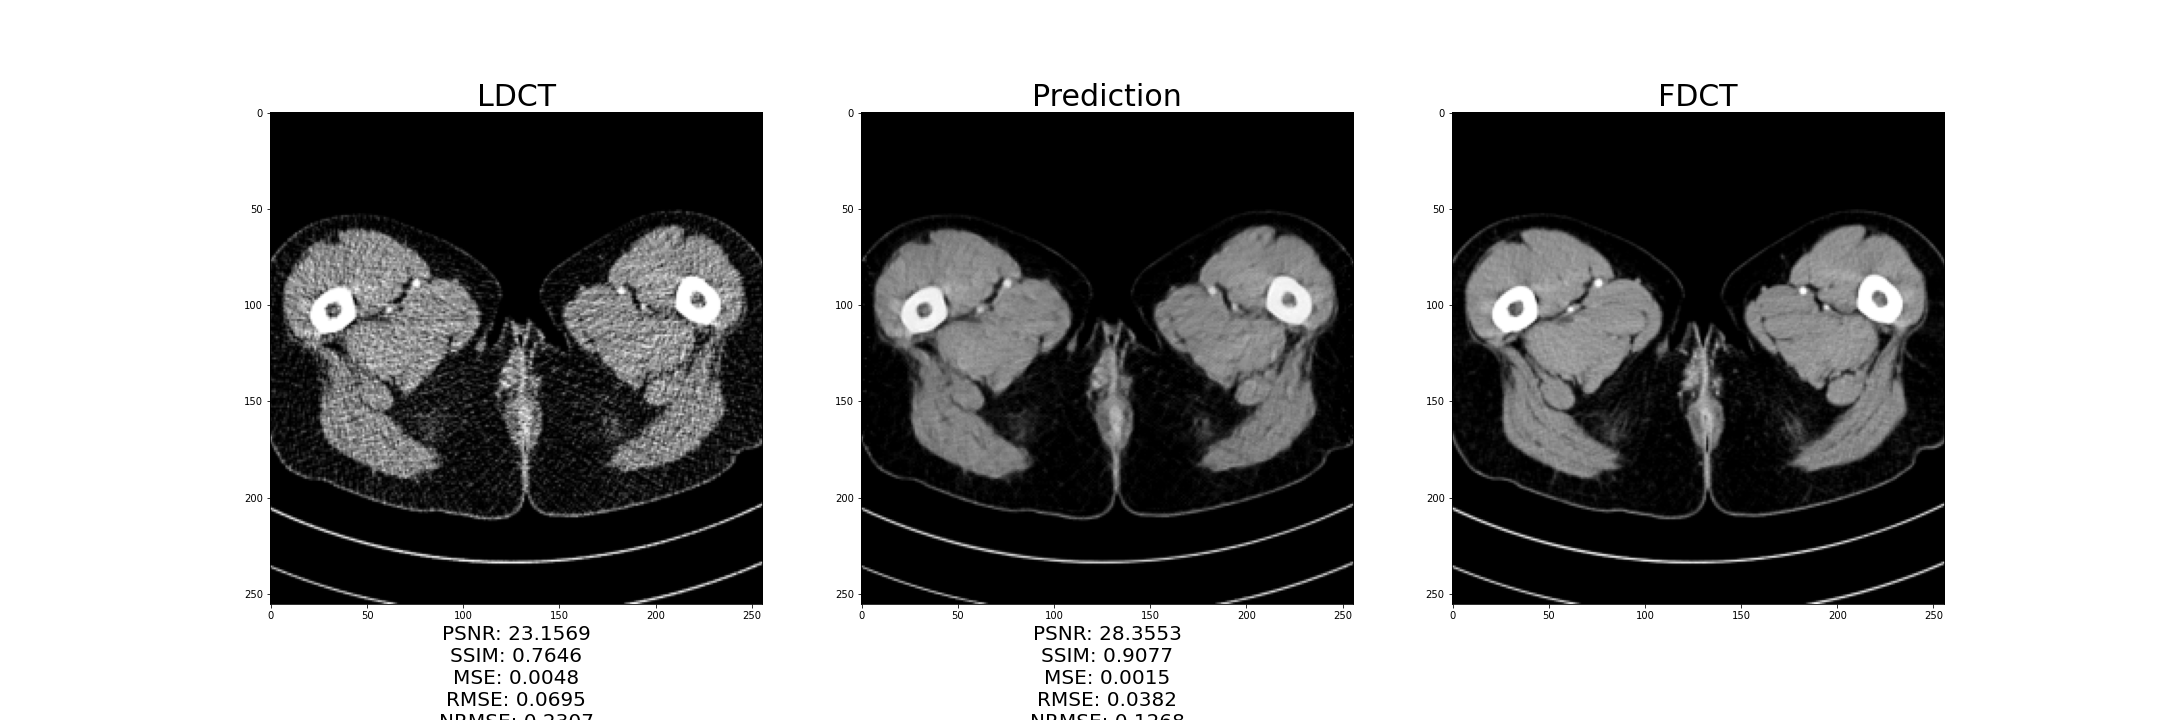

In [ ]:
Image('/content/result_0.png')

# Consistency Plots

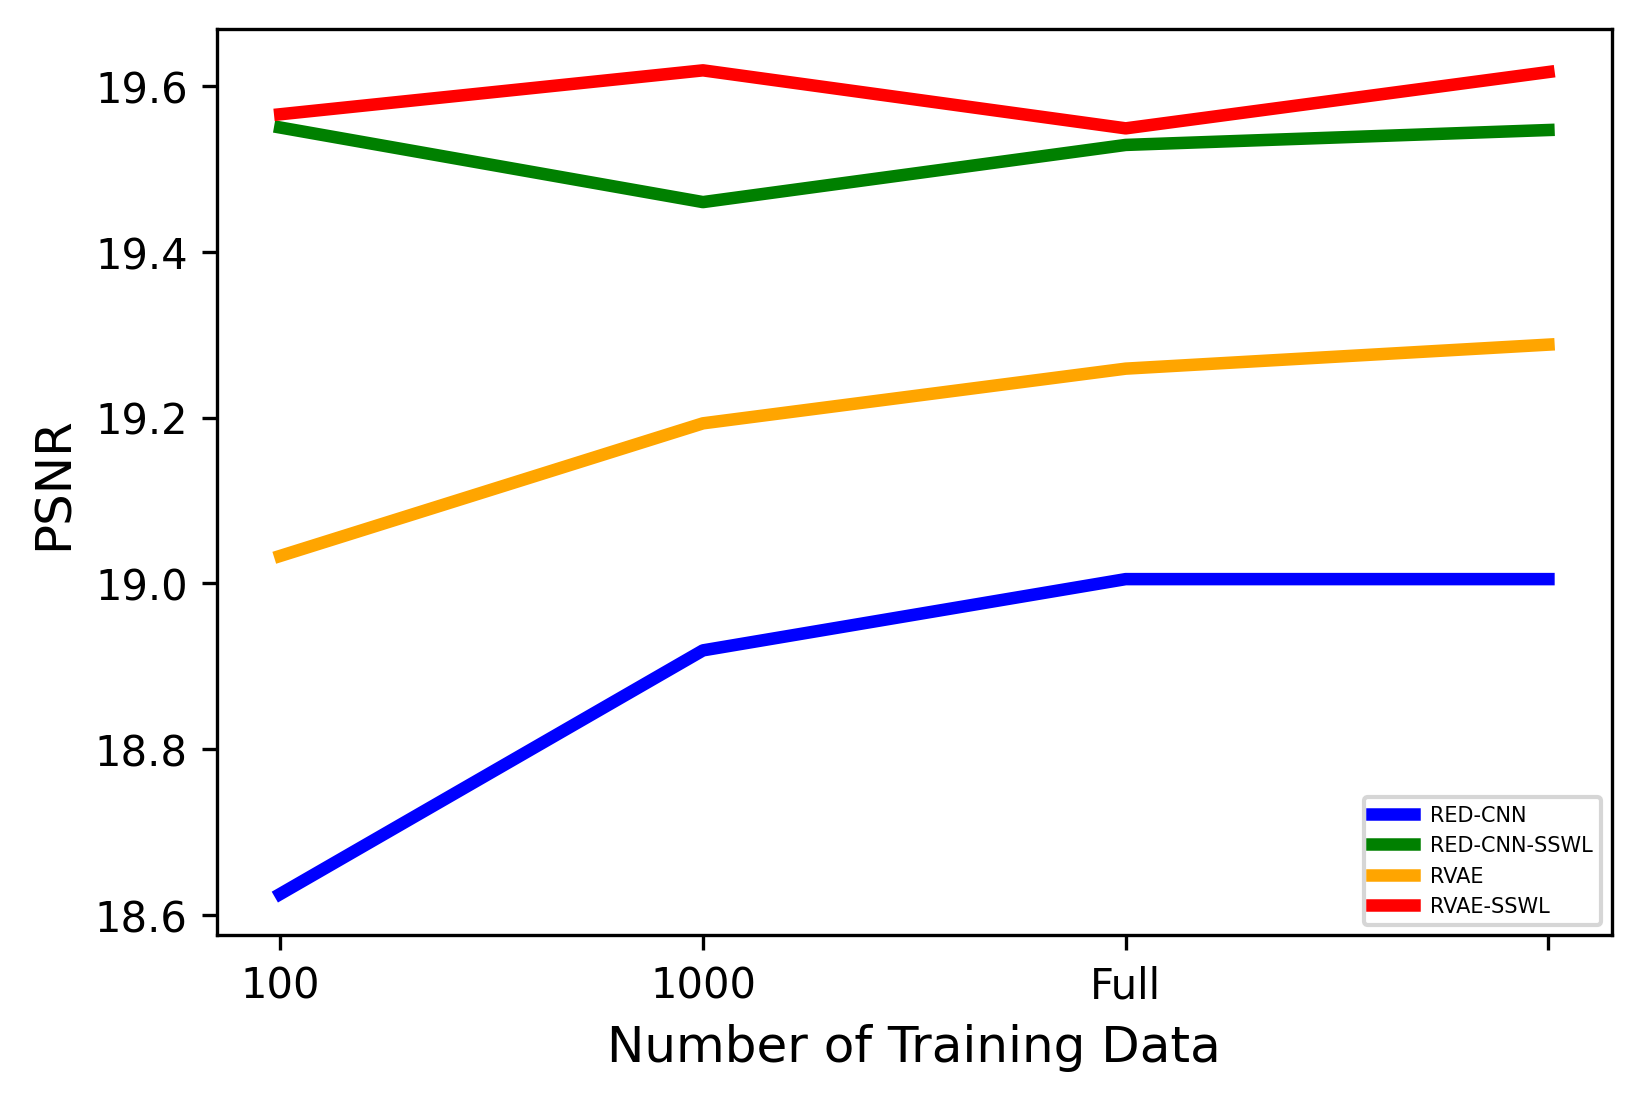

In [ ]:
#PSNR consistency plot

# dncnn = [19.814, 20.430, 21.693, 21.186]
# dncnn_wl = [24.767, 25.284, 25.564, 25.903]
# redcnn = [23.414, 23.612, 24.097, 24.115]
# redcnn_wl = [26.119, 26.300, 26.710, 26.747]
# rvae = [24.829, 26.139, 26.286, 26.574]
# rvae_wl = [26.140, 26.464, 26.799, 26.844]

# cross domain
redcnn = [18.625, 18.919, 19.005, 19.005]
redcnn_wl = [19.550, 19.460, 19.529, 19.547]
rvae = [19.033, 19.193, 19.259, 19.288]
rvae_wl = [19.566, 19.619, 19.549, 19.617]

tck = ["250", "500", "1000", "Full"] #Data proportion


plt.figure(dpi=300)

plt.xticks(range(4), ["100", "1000", "Full"])
# plt.plot(dncnn, 'pink', label = 'DnCNN', linewidth=3)
# plt.plot(dncnn_wl, 'purple', label = 'DnCNN-SSWL', linewidth=3)
plt.plot(redcnn, 'blue', label = 'RED-CNN', linewidth=3)
plt.plot(redcnn_wl, 'green', label = 'RED-CNN-SSWL', linewidth=3)
plt.plot(rvae, 'orange', label = 'RVAE', linewidth=3)
plt.plot(rvae_wl, 'red', label = 'RVAE-SSWL', linewidth=3)
plt.xlabel('Number of Training Data', fontsize=12)
plt.ylabel('PSNR', fontsize=12)
# plt.legend(labels=labels)
plt.legend(loc='lower right', prop={'size': 5})
plt.savefig("cross_psnr_consistency.pdf")
# plt.close()
# plt.xticks(range(6), ['5$%$', '10$%$', '20$%$', '30$%$', '50$%$', '100$%$'], color='red')

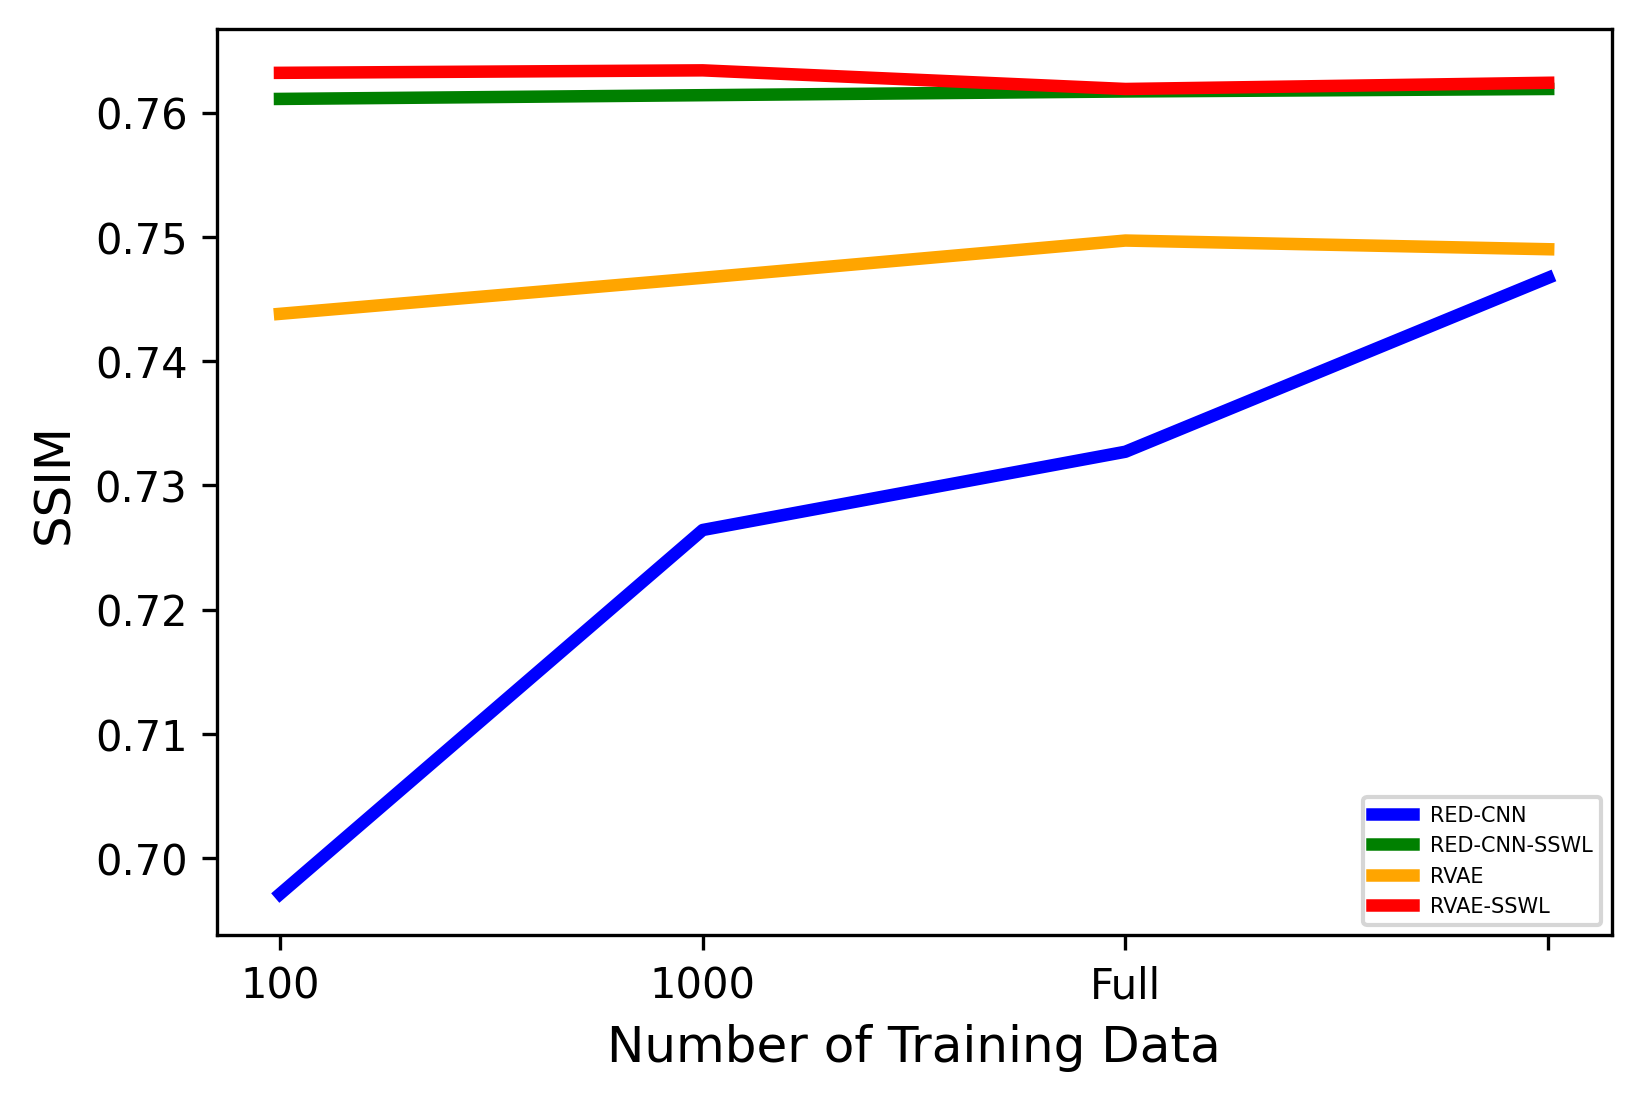

In [ ]:
#SSIM consistency plot

# dncnn = [0.7031, 0.7372, .7460, .7907]
# dncnn_wl = [.8616, .8639, .8650, .8663]
# redcnn = [.8433, 0.8522, 0.8538, 0.8616]
# redcnn_wl = [.8509, 0.8542, 0.8626, 0.8626]
# rvae = [.8483, 0.8538, 0.8626, 0.8646]
# rvae_wl = [0.8612, 0.8659, 0.8669, 0.8701]

# cross domain
redcnn = [.6971, 0.7264, 0.7327, 0.7467]
redcnn_wl = [.7611, 0.7614, 0.7617, 0.7619]
rvae = [.7438, 0.7467, 0.7497, 0.7490]
rvae_wl = [0.7632, 0.7634, 0.7619, 0.7624]

tck = ["250", "500", "1000", "Full"] #Data proportion

plt.figure(dpi=300)

plt.xticks(range(4), ["100", "1000", "Full"], color='black')
# plt.plot(dncnn, 'pink', label = 'DnCNN', linewidth=3)
# plt.plot(dncnn_wl, 'purple', label = 'DnCNN-SSWL', linewidth=3)
plt.plot(redcnn, 'blue', label = 'RED-CNN', linewidth=3)
plt.plot(redcnn_wl, 'green', label = 'RED-CNN-SSWL', linewidth=3)
plt.plot(rvae, 'orange', label = 'RVAE', linewidth=3)
plt.plot(rvae_wl, 'red', label = 'RVAE-SSWL', linewidth=3)
plt.xlabel('Number of Training Data', fontsize=12)
plt.ylabel('SSIM', fontsize=12)
# plt.legend(labels=labels)
plt.legend(loc='lower right', prop={'size': 5})
plt.savefig("cross_ssim_consistency.pdf")
# plt.close()
# plt.xticks(range(6), ['5$%$', '10$%$', '20$%$', '30$%$', '50$%$', '100$%$'], color='red')

# Prediction Plots

In [23]:
model_files = glob("/content/drive/MyDrive/SSL_Ayaan/tests/ssl/nac/redcnn_nac/*")
model_files

['/content/drive/MyDrive/SSL_Ayaan/tests/ssl/nac/redcnn_nac/redcnn_nac_250.pth',
 '/content/drive/MyDrive/SSL_Ayaan/tests/ssl/nac/redcnn_nac/redcnn_nac_500.pth',
 '/content/drive/MyDrive/SSL_Ayaan/tests/ssl/nac/redcnn_nac/redcnn_nac_1000.pth',
 '/content/drive/MyDrive/SSL_Ayaan/tests/ssl/nac/redcnn_nac/redcnn_nac_full.pth',
 '/content/drive/MyDrive/SSL_Ayaan/tests/ssl/nac/redcnn_nac/redcnn_nac_250 (1).pth',
 '/content/drive/MyDrive/SSL_Ayaan/tests/ssl/nac/redcnn_nac/redcnn_nac_500 (1).pth',
 '/content/drive/MyDrive/SSL_Ayaan/tests/ssl/nac/redcnn_nac/redcnn_nac_1000 (1).pth',
 '/content/drive/MyDrive/SSL_Ayaan/tests/ssl/nac/redcnn_nac/redcnn_nac_full (1).pth',
 '/content/drive/MyDrive/SSL_Ayaan/tests/ssl/nac/redcnn_nac/redcnn_nac_250 (2).pth',
 '/content/drive/MyDrive/SSL_Ayaan/tests/ssl/nac/redcnn_nac/redcnn_nac_500 (2).pth',
 '/content/drive/MyDrive/SSL_Ayaan/tests/ssl/nac/redcnn_nac/redcnn_nac_full (2).pth',
 '/content/drive/MyDrive/SSL_Ayaan/tests/ssl/nac/redcnn_nac/redcnn_nac_250 (

In [24]:
file = model_files[10]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RED_CNN().to(device)
# model = DnCNN().to(device)
# model = UNet().to(device)
# model = Autoencoder().to(device)
# model = VanillaVAE().to(device)
# model = VAE_RED_CNN().to(device)

model.load_state_dict(torch.load(file))

model.eval() 

vae_bool = False
pred_masks = []
inputs_arr = []
targets_arr = []

with torch.no_grad():
  print("starting validation")
  for inputs, targets in cross_dataloader['test']:
    gc.collect()
    torch.cuda.empty_cache()

    inputs = inputs.to(device=device, dtype=torch.float)
    targets = targets.to(device=device, dtype=torch.float)
    if vae_bool:
      pred, _, _ = model(inputs)
    else:
      pred = model(inputs)
    pred = pred.data.cpu().numpy()
    inputs_np = inputs.data.cpu().numpy()
    targets_np = targets.data.cpu().numpy()
    for i in range (len(pred)):
      inputs_arr.append(inputs_np[i])
      targets_arr.append(targets_np[i])
      pred_masks.append(pred[i])

inputs_arr = np.reshape(inputs_arr, [-1, 256, 256, 1])
targets_arr = np.reshape(targets_arr, [-1, 256, 256, 1])
pred_masks = np.reshape(pred_masks, [-1, 256, 256, 1])

starting validation


In [78]:
def roi_fig(x, y, pred, x1, y1, w, h, fig_name, save_path = "/content/"):

    # x = x[x1:x2, y1:y2]
    # pred = pred[x1:x2, y1:y2]
    # y = y[x1:x2, y1:y2]

    f, ax = plt.subplots(1, 4, figsize=(40, 10))

    ax[0].imshow(np.squeeze(x), cmap=plt.cm.gray)
    # Create a Rectangle patch
    rect = patches.Rectangle((x1, y1), w, h, linewidth=1, edgecolor='r', facecolor='none')
    ax[0].add_patch(rect)
    ax[0].axis('off')

    ax[1].imshow(np.squeeze(x)[y1:y1+h, x1:x1+w], cmap=plt.cm.gray)
    ax[1].axis('off')

    ax[2].imshow(np.squeeze(pred)[y1:y1+h, x1:x1+w], cmap=plt.cm.gray)
    ssim = skmetrics.structural_similarity(np.squeeze(pred)[y1:y1+h, x1:x1+w], np.squeeze(y)[y1:y1+h, x1:x1+w])
    # ax[2].set_xlabel("SSIM: {:.4f}".format(ssim), fontsize=25)
    ax[2].text(17, 52, "SSIM: {:.4f}".format(ssim), fontsize = 20)
    ax[2].axis('off')

    ax[3].imshow(np.squeeze(y)[y1:y1+h, x1:x1+w], cmap=plt.cm.gray)
    ax[3].axis('off')

    f.savefig(os.path.join(save_path, '{}.pdf'.format(fig_name)))
    # plt.close()

In [81]:
def three_fig(x, y, pred, fig_name, save_path = "/content/"):

    _, pred_result = compute_measure(x, y, pred)

    f, ax = plt.subplots(1, 3, figsize=(30, 10))
    ax[0].imshow(np.squeeze(x), cmap=plt.cm.gray)
    # ax[0].set_title('LDCT', fontsize=30)
    ax[0].axis('off')

    ax[1].imshow(np.squeeze(pred), cmap=plt.cm.gray)
    # ax[1].set_title('Prediction', fontsize=30)
    # ax[1].set_xlabel("PSNR: {:.4f}, SSIM: {:.4f}\nMSE: {:.4f}, NRMSE: {:.4f}".format(pred_result[0],
    #                                                                     pred_result[1],
    #                                                                     pred_result[2],
    #                                                                     pred_result[4]), fontsize=25)
    ax[1].axis('off')
    ax[1].text(54, 280, "PSNR: {:.4f}, SSIM: {:.4f}\nMSE: {:.4f}, NRMSE: {:.4f}".format(pred_result[0],
                                                                        pred_result[1],
                                                                        pred_result[2],
                                                                        pred_result[4]), fontsize = 20)

    ax[2].imshow(np.squeeze(y), cmap=plt.cm.gray)
    # ax[2].set_title('FDCT', fontsize=30)
    ax[2].axis('off')

    f.savefig(os.path.join(save_path, '{}.pdf'.format(fig_name)), facecolor = 'blue')
    # plt.close()

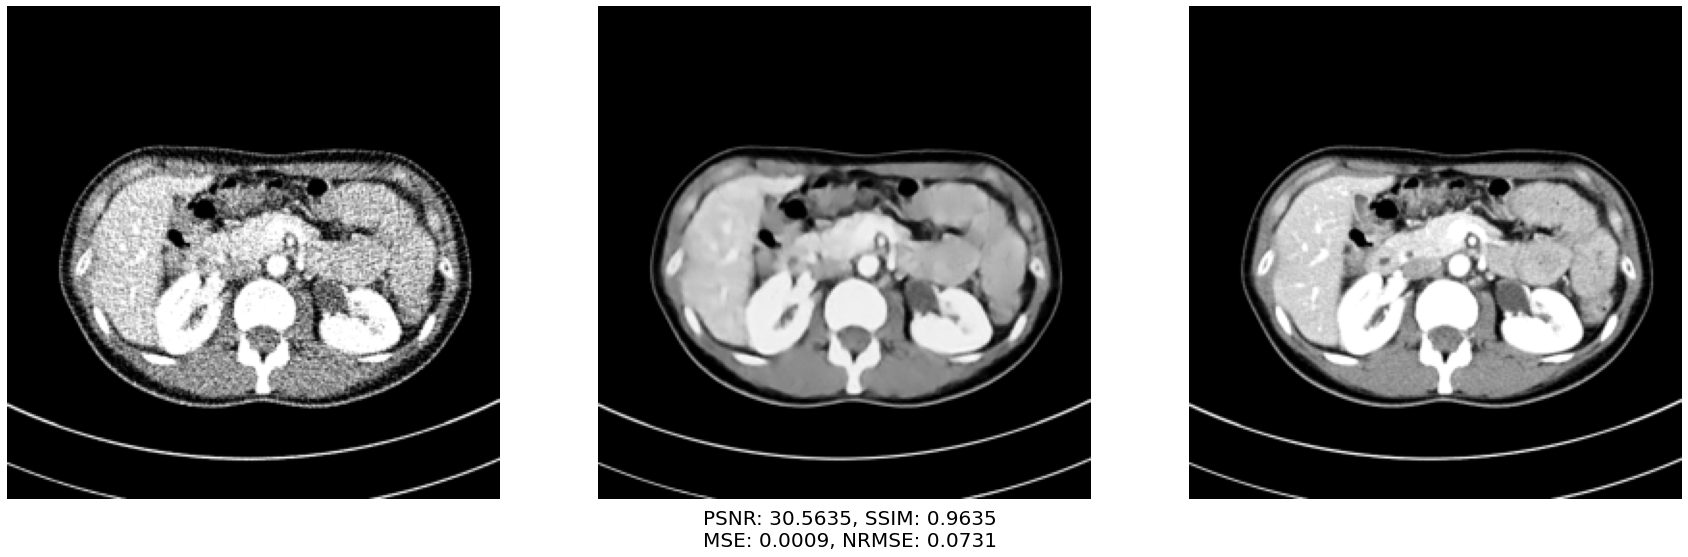

In [82]:
index = 100
x1 = 120
y1 = 90
w = 50
h = 50
three_fig(inputs_arr[index], targets_arr[index], pred_masks[index], "cross_threeplot_sswl-idn" + str(index))
# roi_fig(inputs_arr[index], targets_arr[index], pred_masks[index], x1, y1, w, h, "roi_rvae_sswl" + str(index))

# Comparison Plots

In [113]:
model_files = glob("/content/drive/MyDrive/SSL_Ayaan/tests/baselines/redcnn/*")
model_files

['/content/drive/MyDrive/SSL_Ayaan/tests/baselines/redcnn/redcnn_500.pth',
 '/content/drive/MyDrive/SSL_Ayaan/tests/baselines/redcnn/redcnn_250.pth',
 '/content/drive/MyDrive/SSL_Ayaan/tests/baselines/redcnn/redcnn_250 (1).pth',
 '/content/drive/MyDrive/SSL_Ayaan/tests/baselines/redcnn/redcnn_750.pth',
 '/content/drive/MyDrive/SSL_Ayaan/tests/baselines/redcnn/redcnn_1000.pth',
 '/content/drive/MyDrive/SSL_Ayaan/tests/baselines/redcnn/redcnn_500 (1).pth',
 '/content/drive/MyDrive/SSL_Ayaan/tests/baselines/redcnn/redcnn_full.pth',
 '/content/drive/MyDrive/SSL_Ayaan/tests/baselines/redcnn/redcnn_250 (2).pth',
 '/content/drive/MyDrive/SSL_Ayaan/tests/baselines/redcnn/redcnn_500 (2).pth',
 '/content/drive/MyDrive/SSL_Ayaan/tests/baselines/redcnn/redcnn_250 (3).pth',
 '/content/drive/MyDrive/SSL_Ayaan/tests/baselines/redcnn/redcnn_750 (1).pth',
 '/content/drive/MyDrive/SSL_Ayaan/tests/baselines/redcnn/redcnn_1000 (1).pth',
 '/content/drive/MyDrive/SSL_Ayaan/tests/baselines/redcnn/redcnn_250 

In [118]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RED_CNN().to(device)
# model = DnCNN().to(device)
# model = UNet().to(device)
# model = Autoencoder().to(device)
# model = VanillaVAE().to(device)
# model = VAE_RED_CNN().to(device)

file = model_files[4]

model.load_state_dict(torch.load(file))

model.eval() 

vae_bool = False
pred_masks = []
inputs_arr = []
targets_arr = []

with torch.no_grad():
  print("starting validation")
  for inputs, targets in dataloader['test']:
    gc.collect()
    torch.cuda.empty_cache()

    inputs = inputs.to(device=device, dtype=torch.float)
    targets = targets.to(device=device, dtype=torch.float)
    if vae_bool:
      pred, _, _ = model(inputs)
    else:
      pred = model(inputs)
    pred = pred.data.cpu().numpy()
    inputs_np = inputs.data.cpu().numpy()
    targets_np = targets.data.cpu().numpy()
    for i in range (len(pred)):
      inputs_arr.append(inputs_np[i])
      targets_arr.append(targets_np[i])
      pred_masks.append(pred[i])

inputs_arr = np.reshape(inputs_arr, [-1, 256, 256, 1])
targets_arr = np.reshape(targets_arr, [-1, 256, 256, 1])
pred_masks = np.reshape(pred_masks, [-1, 256, 256, 1])

starting validation


In [119]:
def single_pred(x, y, pred, fig_name, save_path = "/content/"):

    _, pred_result = compute_measure(x, y, pred)

    plt.imshow(np.squeeze(pred), cmap=plt.cm.gray)
    plt.axis('off')
    plt.text(43, 280, "PSNR: {:.4f}, SSIM: {:.4f}\nMSE: {:.4f}, NRMSE: {:.4f}".format(pred_result[0],
                                                                        pred_result[1],
                                                                        pred_result[2],
                                                                        pred_result[4]))
    # plt.xlabel("PSNR: {:.4f}, SSIM: {:.4f}\nMSE: {:.4f}, NRMSE: {:.4f}".format(pred_result[0],
    #                                                                     pred_result[1],
    #                                                                     pred_result[2],
    #                                                                     pred_result[4]), fontsize=10)

    plt.savefig(os.path.join(save_path, '{}.pdf'.format(fig_name)))
    # plt.close()

In [120]:
# for i in range(len(inputs_arr)):
#   pred_result = compute_measure(inputs_arr[i], targets_arr[i], inputs_arr[i])
#   print(str(i) + str(pred_result[1]))

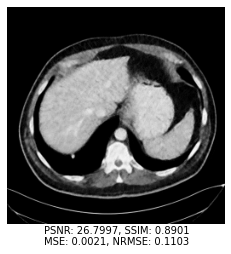

In [121]:
index = 219
# single_pred(inputs_arr[index], targets_arr[index], inputs_arr[index], "input_" + str(index))
single_pred(inputs_arr[index], targets_arr[index], pred_masks[index], "redcnn_nw_" + str(index))

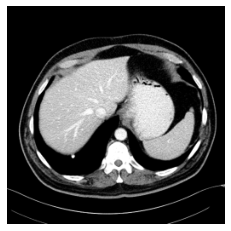

In [101]:
plt.imshow(np.squeeze(targets_arr[index]), cmap = 'gray')
plt.axis("off")
plt.savefig("gt_" + str(index) + ".pdf", facecolor='blue')

In [74]:
def single_roi(x, y, pred, x1, y1, w, h, fig_name, save_path = "/content/"):

    plt.imshow(np.squeeze(pred)[y1:y1+h, x1:x1+w], cmap=plt.cm.gray)
    ssim = skmetrics.structural_similarity(np.squeeze(pred)[y1:y1+h, x1:x1+w], np.squeeze(y)[y1:y1+h, x1:x1+w])
    # ax[2].set_xlabel("SSIM: {:.4f}".format(ssim), fontsize=25)
    # plt.text(13, 53, "SSIM: {:.4f}".format(ssim), fontsize = 15)
    print(ssim)
    plt.axis('off')

    plt.savefig(os.path.join(save_path, '{}.pdf'.format(fig_name)))
    # plt.close()

0.7674638872425575


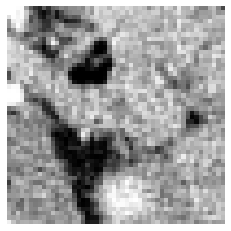

In [75]:
index = 85
x1 = 150
y1 = 110
w = 50
h = 50

# three_fig(inputs_arr[index], targets_arr[index], pred_masks[index], "threeplot_sswl-idn" + str(index))
# single_roi(inputs_arr[index], targets_arr[index], pred_masks[index], x1, y1, w, h, "single_roi_rvae_sswl_" + str(index))
single_roi(inputs_arr[index], targets_arr[index], inputs_arr[index], x1, y1, w, h, "single_roi_rvae_ldct_" + str(index))

AttributeError: ignored

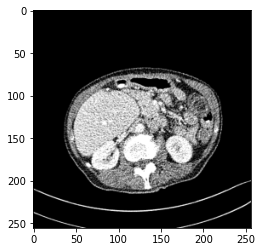

In [ ]:
plt.imshow(np.squeeze(inputs_arr[index]), cmap = 'gray')
rect = patches.Rectangle((x1, y1), w, h, linewidth=1, edgecolor='r', facecolor='none')
plt.add_patch(rect)
plt.axis('off')

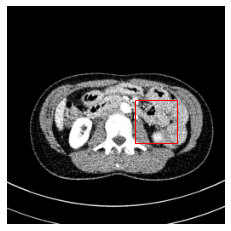

In [ ]:
fig, ax = plt.subplots()

# Display the image
ax.imshow(np.squeeze(inputs_arr[index]), cmap = 'gray')

# Create a Rectangle patch
rect = patches.Rectangle((x1, y1), w, h, linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)
ax.axis('off')

fig.savefig("single_roi_rvae_whole_image_" + str(index) + ".pdf")

plt.show()

# Statistical Significance Tests

In [ ]:
transform = transforms.Compose([
  transforms.ToTensor(),
])

test_dataset = CT_Dataset(inputs = ld_test, targets = fd_test, transform = transform)

test_loader = DataLoader(dataset = test_dataset, batch_size = 10, shuffle = True, num_workers= 0)

dataloader = {
    'test': test_loader
}

print(len(dataloader['test']))

67


In [ ]:
# model.load_state_dict(torch.load(checkpoint_path))
# model.load_state_dict(torch.load("/content/drive/MyDrive/SSL_Ayaan/test_full.pth"))

model_files = glob("/content/drive/MyDrive/SSL_Ayaan/tests/ssl/rec/vae_red_rec/*250*")
print(len(model_files))

def get_name(file):
  name = file.split("/")[9].split(".")[0]
  return name

print(get_name(model_files[0]))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = RED_CNN().to(device)
# model = DnCNN().to(device)
# model = UNet().to(device)
# model = Autoencoder().to(device)
# model = VanillaVAE().to(device)
model = VAE_RED_CNN().to(device)
vae_bool = True

5
vae_red_rec_250


In [ ]:
for file in model_files:

  psnr_scores = []

  model_name = get_name(file)

  model.load_state_dict(torch.load(file))

  with torch.no_grad():
    print("starting validation")
    for inputs, targets in dataloader['test']:
      gc.collect()
      torch.cuda.empty_cache()

      inputs = inputs.to(device=device, dtype=torch.float)
      targets = targets.to(device=device, dtype=torch.float)
      if vae_bool:
        pred, _, _ = model(inputs)
      else:
        pred = model(inputs)
      pred = pred.data.cpu().numpy()
      targets_np = targets.data.cpu().numpy()
      for i in range (len(pred)):
        psnr_scores.append(compute_PSNR(targets_np[i], pred[i]))
    
  psnr_scores = np.asarray(psnr_scores)
  sio.savemat("/content/drive/MyDrive/SSL_Ayaan/tests/psnr_scores/" + model_name + ".mat", {'psnr': psnr_scores})

starting validation
starting validation
starting validation
starting validation
starting validation


In [ ]:
np.mean(psnr_scores)

26.57323575155033

In [ ]:
from scipy.stats import ttest_ind
from scipy.stats import f_oneway

model_1 = sio.loadmat("/content/drive/MyDrive/SSL_Ayaan/tests/psnr_scores/dncnn_250.mat")['psnr'][0]
model_2 = sio.loadmat("/content/drive/MyDrive/SSL_Ayaan/tests/psnr_scores/dncnn_250 (1).mat")['psnr'][0]
model_3 = sio.loadmat("/content/drive/MyDrive/SSL_Ayaan/tests/psnr_scores/dncnn_250 (2).mat")['psnr'][0]
model_4 = sio.loadmat("/content/drive/MyDrive/SSL_Ayaan/tests/psnr_scores/dncnn_250 (3).mat")['psnr'][0]
model_5 = sio.loadmat("/content/drive/MyDrive/SSL_Ayaan/tests/psnr_scores/dncnn_250 (4).mat")['psnr'][0]
model_scores = [model_1, model_2, model_3, model_4, model_5]

rvae_1 = sio.loadmat("/content/drive/MyDrive/SSL_Ayaan/tests/psnr_scores/vae_red_nw_250.mat")['psnr'][0]
rvae_2 = sio.loadmat("/content/drive/MyDrive/SSL_Ayaan/tests/psnr_scores/vae_red_nw_250 (1).mat")['psnr'][0]
rvae_3 = sio.loadmat("/content/drive/MyDrive/SSL_Ayaan/tests/psnr_scores/vae_red_nw_250 (2).mat")['psnr'][0]
rvae_4 = sio.loadmat("/content/drive/MyDrive/SSL_Ayaan/tests/psnr_scores/vae_red_nw_250 (3).mat")['psnr'][0]
rvae_5 = sio.loadmat("/content/drive/MyDrive/SSL_Ayaan/tests/psnr_scores/vae_red_nw_250 (4).mat")['psnr'][0]
rvae_scores = [rvae_1, rvae_2, rvae_3, rvae_4, rvae_5]

total = []

for model in model_scores:
  for rvae in rvae_scores:
    # pdb.set_trace()
    pvalue = ttest_ind(model, rvae).pvalue
    total.append(pvalue)
    print("P-Value of RVAE (PSNR) " + str(pvalue))

print("Average P-Value: "  + str(np.mean(total)))

P-Value of RVAE (PSNR) 1.8258392805531156e-103
P-Value of RVAE (PSNR) 9.944422209852134e-106
P-Value of RVAE (PSNR) 2.958863915298835e-110
P-Value of RVAE (PSNR) 1.8144777058836228e-107
P-Value of RVAE (PSNR) 3.596004199833543e-110
P-Value of RVAE (PSNR) 5.1772327980958384e-117
P-Value of RVAE (PSNR) 2.1903733835976457e-119
P-Value of RVAE (PSNR) 2.2806270905845725e-124
P-Value of RVAE (PSNR) 2.77010114271147e-121
P-Value of RVAE (PSNR) 3.997347073749737e-124
P-Value of RVAE (PSNR) 8.424634650846935e-85
P-Value of RVAE (PSNR) 5.5332397670821226e-87
P-Value of RVAE (PSNR) 3.71656228933283e-91
P-Value of RVAE (PSNR) 1.343297715695502e-88
P-Value of RVAE (PSNR) 3.336143013585544e-91
P-Value of RVAE (PSNR) 1.6443588692388605e-118
P-Value of RVAE (PSNR) 6.189675768227062e-121
P-Value of RVAE (PSNR) 4.211947245938984e-126
P-Value of RVAE (PSNR) 6.742217346954051e-123
P-Value of RVAE (PSNR) 8.391097409842194e-126
P-Value of RVAE (PSNR) 2.8923341106772235e-112
P-Value of RVAE (PSNR) 1.27423799